In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

- Copper: HG
- Bund: RX
- Crude Oil: CL
- EURUSD: EC
- Gold: GC
- Nasdaq: NQ
- S&P500 Mini: ES
- Silver: SI
- Soybeans: SO
- UST: TY

In [2]:
# User-specified parameters for empirical PDF generation
ticker = "GC"                           # Ticker of underlying
interval = 15                           # Holding period: 5, 10, 15, 30, 60 minutes
partitions = [0.65, 0.8]                # Train, cross-validation, and test set split


# Load dataset for user-specified ticker
with open("clean-data/futures_ticks.pkl", "rb") as f:
    tick_size = pickle.load(f)[ticker]
futures_df = pd.read_csv(f"./clean-data/{ticker}.csv", index_col='datetime', parse_dates=True)

# Resample training set into user-specified intervals
resampled_o = futures_df['open'].resample(f"{interval}min").first()
resampled_h = futures_df['high'].resample(f"{interval}min").max()
resampled_l = futures_df['low'].resample(f"{interval}min").min()
resampled_c = futures_df['close'].resample(f"{interval}min").last()
resampled_v = futures_df['volume'].resample(f"{interval}min").sum()
futures_df = pd.DataFrame(
    {
        'open': resampled_o,
        'high': resampled_h,
        'low': resampled_l,
        'close': resampled_c,
        'volume': resampled_v,
    }
)
futures_df.dropna(inplace=True)

# Partition resampled dataset into training, cross-validation, and test sets
train_df = futures_df.iloc[:int(partitions[0]*len(futures_df))].copy()
cv_df = futures_df.iloc[:int(partitions[1]*len(futures_df))].copy()
test_df = futures_df.copy()

# Construct Range, RangeUp, RangeDown responses for training set
train_df["fwd_range"] = ((train_df["high"] - train_df["low"]) / tick_size).shift(-1)
train_df["fwd_range_up"] = ((train_df["high"] - train_df["open"]) / tick_size).shift(-1)
train_df["fwd_range_down"] = ((train_df["open"] - train_df["low"]) / tick_size).shift(-1)

# Define feature and repsonse names
features = ["delta_feat", "vol_feat", "volume_feat"]
responses = ["fwd_range", "fwd_range_up", "fwd_range_down"]

In [3]:
def volume_function(series, param):
    # Raw volumes for each period
    if param == 1:
        return series
    
    # Simple moving average over (param) rolling window
    if param > 1:
        return series.rolling(param).mean()
    
    # Exponential moving average with (param) decay
    if param < 1:
        return series.ewm(alpha=param, adjust=False).mean()

def vol_function(series, param):
    # Standard deviation from simple mean over (param) rolling window
    if param > 1:
        return series.rolling(param).std()
    
    # Standard deviation from exponential moving average with (param) decay
    if param < 1:
        ema = series.ewm(alpha=param, adjust=False).mean()
        square_dev = (ema - series)**2
        return square_dev.ewm(alpha=param, adjust=False).mean()

In [4]:
def epdf_construction(volume_param, vol_param):
    # Construct volume, volatility and delta features
    tuning_df = train_df.copy()
    tuning_df["delta_feat"] = tuning_df["close"].diff()
    tuning_df["volume_feat"] = volume_function(tuning_df["volume"], volume_param)
    tuning_df["vol_feat"] = vol_function(tuning_df["delta_feat"], vol_param)
    tuning_df.dropna(inplace=True)

    # Find optimal number of regimes from a KMeans clustering algorithm
    n_regimes = [_ for _ in range(2, 8)]
    regime_wcss = []
    for reg in n_regimes:
        kmeans = KMeans(n_clusters=reg, random_state=10).fit(tuning_df[features])
        regime_wcss.append(kmeans.inertia_)
    regimes = KneeLocator(n_regimes, regime_wcss, curve="convex", direction="decreasing").knee

    # Build empirical PDF for each response and regime
    kmeans = KMeans(n_clusters=regimes, random_state=10)
    tuning_df["regime"] = kmeans.fit_predict(tuning_df[features])
    regime_obs = tuning_df["regime"].value_counts()
    empirical_pdfs = {resp: tuning_df[[resp, "regime"]].groupby("regime").value_counts() / regime_obs for resp in responses}

    return regimes, kmeans, empirical_pdfs

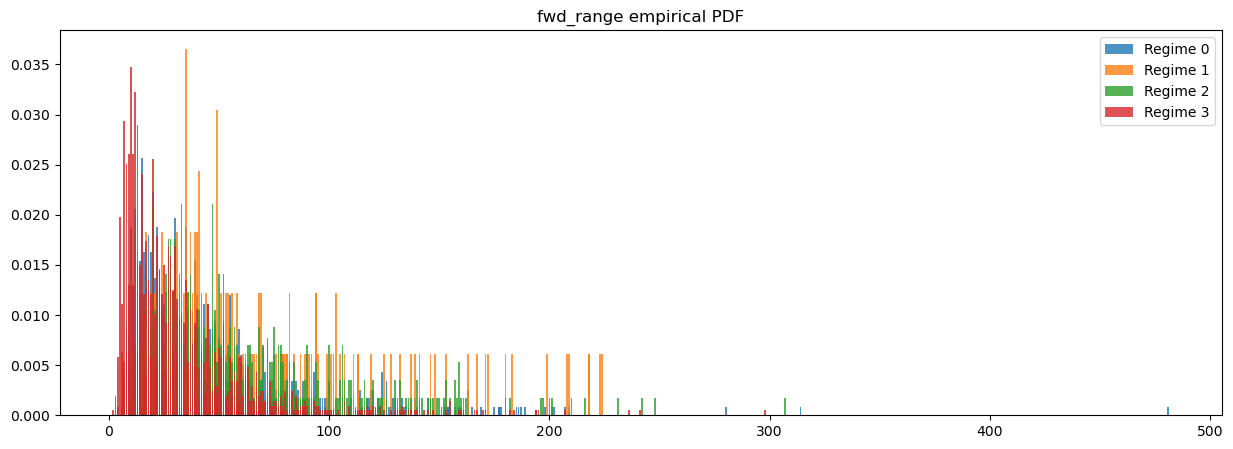

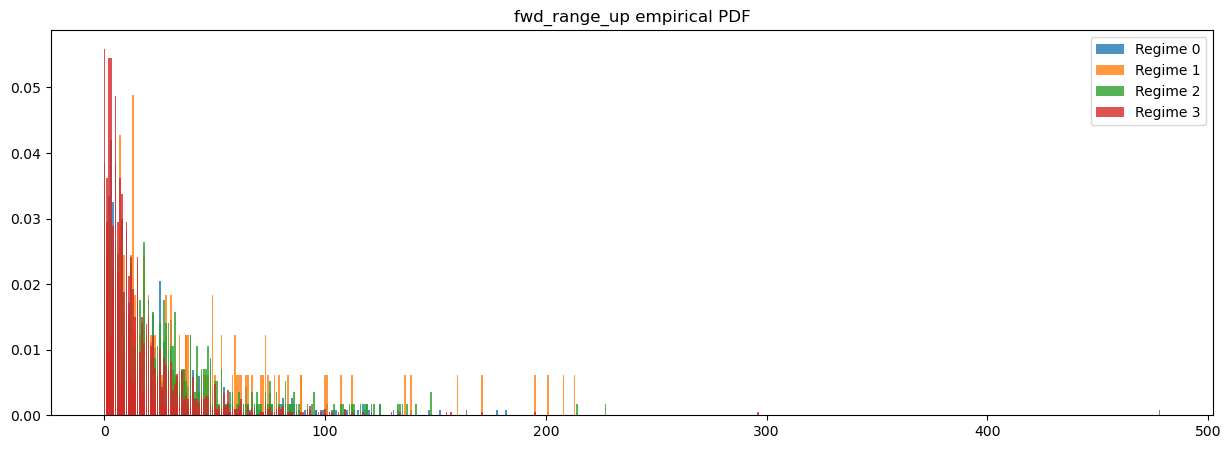

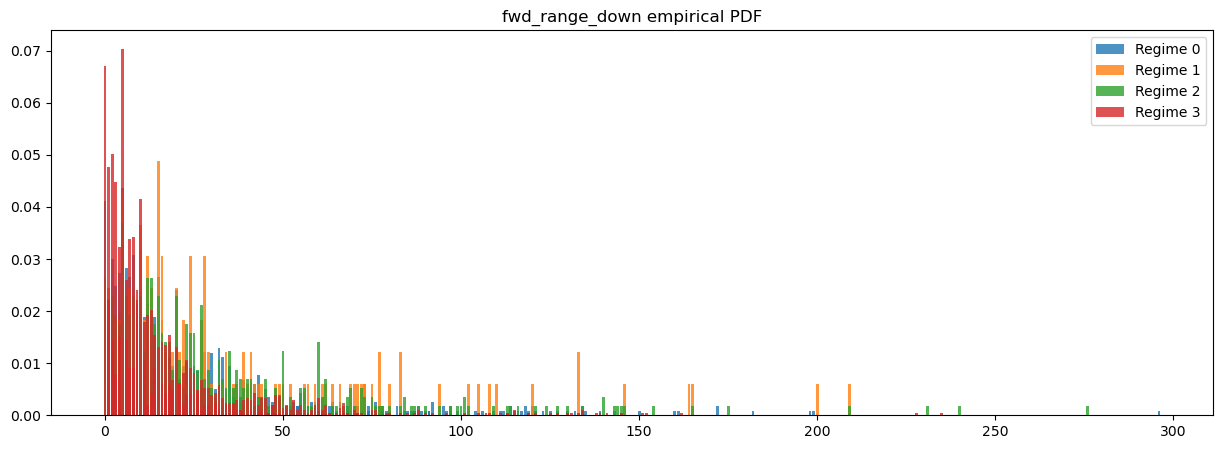

In [5]:
# Plot empirical PDFs given volume and volatility feature functions
def plot_epdfs(volume_param, vol_param):
    regimes, _, epdfs = epdf_construction(volume_param, vol_param)
    for response, df in epdfs.items():
        plt.figure(figsize=(15, 5))
        plt.title(f"{response} empirical PDF")
        for i in range(regimes):
            plt.bar(df[i].keys(), df[i].values, label=f"Regime {i}", alpha=0.8)
        plt.legend()

plot_epdfs(5, 30)

In [6]:
cv_df["fwd_range"] = ((cv_df["high"] - cv_df["low"]) / tick_size).shift(-1)
cv_df["fwd_range_up"] = ((cv_df["high"] - cv_df["open"]) / tick_size).shift(-1)
cv_df["fwd_range_down"] = ((cv_df["open"] - cv_df["low"]) / tick_size).shift(-1)

# Define log-likelihood computation algorithm for cross-validation optimization
def log_likelihood(kmeans, epdfs, volume_param, vol_param):
    optimizing_df = cv_df.copy()
    optimizing_df["delta_feat"] = optimizing_df["close"].diff()
    optimizing_df["volume_feat"] = volume_function(optimizing_df["volume"], volume_param)
    optimizing_df["vol_feat"] = vol_function(optimizing_df["delta_feat"], vol_param)
    optimizing_df = optimizing_df.iloc[int(partitions[0]*len(futures_df)):].copy()
    optimizing_df.dropna(inplace=True)
    optimizing_df["regime"] = kmeans.predict(optimizing_df[features])

    log_likelihoods = {}
    for resp in responses:
        resp_reg_df = optimizing_df[[resp, "regime"]]
        resp_pdf = np.log(epdfs[resp])
        obs_df = resp_reg_df.groupby("regime").value_counts()
        resp_log_likelihood = 0
        for reg in optimizing_df["regime"].unique():
            reg_obs_df = obs_df[reg]
            reg_resp_pdf = resp_pdf[reg]
            zero_ll = reg_resp_pdf.min()
            for spread, obs in reg_obs_df.items():
                resp_log_likelihood += obs * reg_resp_pdf.get(spread, zero_ll)
                
        log_likelihoods[resp] = resp_log_likelihood

    return log_likelihoods

In [7]:
volume_param_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 15, 20, 25]
vol_param_list = [0.1, 0.3, 0.5, 0.7, 0.9, 30, 40, 50, 60]

# Get log-likelihood for a set of volume and volatility function parameters
optimization_results = []
for volume_param in volume_param_list:
    for vol_param in vol_param_list:
        _, _kmeans, _epdfs = epdf_construction(volume_param, vol_param)
        _log_likelihood = log_likelihood(_kmeans, _epdfs, volume_param, vol_param)
        _log_likelihood["volume_param"] = volume_param
        _log_likelihood["vol_param"] = vol_param
        optimization_results.append(_log_likelihood)

optimization_df = pd.DataFrame(optimization_results)

optimization_df

,fwd_range,fwd_range_up,fwd_range_down,volume_param,vol_param
0,-4647.892614,-4098.406679,-4224.125273,0.1,0.1
1,-4647.892614,-4098.406679,-4224.125273,0.1,0.3
2,-4647.435201,-4098.814064,-4223.887386,0.1,0.5
3,-4647.435201,-4098.814064,-4223.887386,0.1,0.7
4,-4647.435201,-4098.814064,-4223.887386,0.1,0.9
...,...,...,...,...,...
94,-4654.431886,-4103.313584,-4219.470175,25.0,0.9
95,-4654.500473,-4101.643841,-4220.164485,25.0,30.0
96,-4654.811394,-4102.582745,-4219.361528,25.0,40.0
97,-4655.460895,-4105.895460,-4224.414358,25.0,50.0
